In [80]:
from pathlib import Path
from datetime import datetime, timezone
import pandas as pd, numpy as np, re, glob, json
import matplotlib.pyplot as plt
import os

# Püüa leida repo juur ja OUT_DIR sõltumatult käivituskaustast
def find_base_dir() -> Path:
    # Kinnita kandidaadid: cwd ja vanemkaustad
    candidates = [Path.cwd(), *Path.cwd().parents]
    # Kui kasutaja teadaolev absoluutne rada on olemas, lisa see eelisjärjekorras
    known = Path(r"C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast")
    if known.exists():
        candidates = [known, *candidates]
    # Vali esimene, kus on kaust 'scripts/output'
    for root in candidates:
        if (root/"scripts"/"output").exists():
            return root
    # kui ei leia, kasuta cwd
    return Path.cwd()

BASE_DIR = find_base_dir()
OUT_DIR = BASE_DIR / "scripts" / "output"
QC_DIR  = OUT_DIR / "qc"
QC_DIR.mkdir(parents=True, exist_ok=True)

# Failimuster
GLOB_PATTERN = "forecast_consumption_hourly_next7_tallinn_*.csv"

# Lävendid
THRESH = {
    "max_na_share": 0.01,          # 1% NA
    "warn_na_share": 0.05,
    "max_negative_share": 0.0,     # negatiivseid ei tohi olla
    "hourly_step_miss_tol": 0.00,  # tunnisamm peab olema 1h (1.0 = OK)
    "max_outlier_share": 0.01,     # ≤1% outliere
    "warn_outlier_share": 0.03,
    "drift_rel_30_warn": 0.10,     # 10% tundidest >30% rel. erinevus = WARN (PASS ≤5%)
    "drift_rel_30_pass": 0.05,
    "drift_rel_50_warn": 0.03,     # 3% tundidest >50% rel. erinevus = WARN (PASS ≤1%)
    "drift_rel_50_pass": 0.01,
    "mad_k": 6.0                   # robustne vahemik: median ± k*MAD
}

print("QC baaskaust:", BASE_DIR)
print("Forecast failide kaust:", OUT_DIR.resolve())
print("Forecast muster:", GLOB_PATTERN)
print("QC väljundkaust:", QC_DIR.resolve())

QC baaskaust: C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast
Forecast failide kaust: C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output
Forecast muster: forecast_consumption_hourly_next7_tallinn_*.csv
QC väljundkaust: C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc


In [81]:
# Leia prognoosifailid; kui ei leia, ära viska erandit
patterns = [
    OUT_DIR / GLOB_PATTERN,                 # eelistatud: BASE_DIR/scripts/output
    BASE_DIR / "scripts" / GLOB_PATTERN,   # BASE_DIR/scripts
    BASE_DIR / GLOB_PATTERN,                # BASE_DIR
]

matches = []
for pat in patterns:
    matches.extend(glob.glob(str(pat)))

# deduplikatsioon ja sort
FILES = sorted(dict.fromkeys(matches))

print("Otsisin mustri järgi:")
for pat in patterns:
    print(" -", pat)

if not FILES:
    print(f"Ei leidnud ühtki forecast-faili mustriga: {GLOB_PATTERN}")
    print(f"Oodatud kaust eelisjärjekorras: {OUT_DIR.resolve()}")
    print("Näpunäide: pane prognoosifailid kausta 'scripts/output' ja käivita see rida uuesti.")

pd.DataFrame({"file": [Path(p).name for p in FILES]})

Otsisin mustri järgi:
 - C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\forecast_consumption_hourly_next7_tallinn_*.csv
 - C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\forecast_consumption_hourly_next7_tallinn_*.csv
 - C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\forecast_consumption_hourly_next7_tallinn_*.csv


,file
0,forecast_consumption_hourly_next7_tallinn_2025...
1,forecast_consumption_hourly_next7_tallinn_2025...
2,forecast_consumption_hourly_next7_tallinn_2025...
3,forecast_consumption_hourly_next7_tallinn_2025...


In [82]:
def parse_dates_from_name(path: str):
    """Võta failinimest algus- ja lõppkuupäev (YYYYMMDD_YYYYMMDD)."""
    m = re.search(r"_(\d{8})_(\d{8})\.csv$", Path(path).name)
    if not m:
        return None, None
    s = datetime.strptime(m.group(1), "%Y%m%d").date()
    e = datetime.strptime(m.group(2), "%Y%m%d").date()
    return s, e

def to_num(series: pd.Series) -> pd.Series:
    """Euro-komade talumine."""
    if pd.api.types.is_numeric_dtype(series):
        return series
    s = (series.astype(str)
         .str.replace("\xa0","", regex=False)
         .str.replace(" ","", regex=False)
         .str.replace(",",".", regex=False))
    return pd.to_numeric(s, errors="coerce")

def _read_csv_robust(path: str):
    """Proovi lugeda CSV eri kodeeringute ja eraldajatega. Tagastab (df, encoding, sep)."""
    encodings = ["utf-8", "utf-8-sig", "cp1257", "windows-1257", "cp1252", "latin-1", "iso-8859-1"]
    seps = [";", ","]
    last_err = None
    for enc in encodings:
        for sep in seps:
            try:
                df = pd.read_csv(path, sep=sep, encoding=enc, low_memory=False)
                if len(df.columns) == 1 and sep == ";":
                    continue
                return df, enc, sep
            except Exception as e:
                last_err = f"encoding={enc}, sep='{sep}': {e}"
                continue
    raise RuntimeError(f"Lugemine ebaõnnestus: {path} — {last_err}")

def read_forecast(path: str) -> pd.DataFrame:
    """Loe forecast CSV (toetab ; või ,) ja mitut kodeeringut; standardiseeri veerud."""
    df, used_enc, used_sep = _read_csv_robust(path)

    # Aja veerg
    tcol = next((c for c in ["datetime_hour","datetime_local","timestamp","datetime","aeg"] if c in df.columns), None)
    if tcol is None:
        raise ValueError(f"{Path(path).name}: sobiv aeg/timestamp veerg puudub. Veerud: {list(df.columns)}")
    df["datetime_hour"] = pd.to_datetime(df[tcol], errors="coerce")

    # Ajavöönd -> UTC
    if df["datetime_hour"].dt.tz is None:
        df["datetime_hour"] = df["datetime_hour"].dt.tz_localize("UTC")
    else:
        df["datetime_hour"] = df["datetime_hour"].dt.tz_convert("UTC")

    # Väärtuse veerg
    vcol = next((c for c in ["consumption_hourly","yhat_consumption","yhat_base","forecast"] if c in df.columns), None)
    if vcol is None:
        raise ValueError(f"{Path(path).name}: puudub tarbimise veerg (consumption_hourly / yhat_* / forecast). Veerud: {list(df.columns)}")
    df["consumption_hourly"] = to_num(df[vcol])

    # Puhastus
    df = df.dropna(subset=["datetime_hour"]).sort_values("datetime_hour").reset_index(drop=True)
    return df[["datetime_hour","consumption_hourly"]]

def hourly_step_share(ts: pd.Series) -> float:
    """Mitu % järjestikuseid vahemaid on täpselt 1 tund."""
    if len(ts) < 2:
        return 1.0
    diffs = (ts.iloc[1:].values - ts.iloc[:-1].values) / np.timedelta64(1, "h")
    return float(np.mean(diffs == 1.0))

In [83]:
# Kui faile pole, jäta statistika vahele
if not FILES:
    print("⏭️ Per-file statistika vahele (faile ei leitud)")
else:
    per_file_rows = []
    for p in FILES:
        df = read_forecast(p)
        start_nm, end_nm = parse_dates_from_name(p)
        rows = len(df)
        uniq = df["datetime_hour"].nunique()
        dups = rows - uniq
        exp_hours = None
        if start_nm and end_nm:
            exp_days = (end_nm - start_nm).days + 1
            exp_hours = exp_days * 24
        if rows:
            rng = pd.date_range(df["datetime_hour"].min(), df["datetime_hour"].max(), freq="h", tz="UTC")
            missing_inside = int(len(rng.difference(df["datetime_hour"])))
        else:
            missing_inside = 0
        na_share  = float(df["consumption_hourly"].isna().mean())
        neg_share = float((df["consumption_hourly"] < 0).mean())
        step_ok   = hourly_step_share(df["datetime_hour"])
        per_file_rows.append({
            "file": Path(p).name,
            "rows": rows,
            "unique_ts": uniq,
            "duplicates": dups,
            "expected_hours_from_filename": exp_hours,
            "rows_vs_filename": None if exp_hours is None else ("PASS" if rows==exp_hours else "WARN"),
            "hourly_step_share": step_ok,
            "missing_hours_inside_range": missing_inside,
            "na_share": na_share,
            "negative_share": neg_share,
            "min": float(df["consumption_hourly"].min()),
            "max": float(df["consumption_hourly"].max()),
            "mean": float(df["consumption_hourly"].mean())
        })
    per_file = pd.DataFrame(per_file_rows)
    per_file_path = QC_DIR / "forecast_only_file_stats.csv"
    per_file.to_csv(per_file_path, sep=";", index=False, encoding="utf-8")
    per_file.sort_values("file").reset_index(drop=True)

In [84]:
# Koonda kõik väärtused robustsete piiride jaoks (kui faile on)
if not FILES:
    print("⏭️ Robustsed piirid vahele (faile ei leitud)")
else:
    all_vals = []
    for p in FILES:
        all_vals.append(read_forecast(p).assign(file=Path(p).name))
    all_vals = pd.concat(all_vals, ignore_index=True)
    med = float(all_vals["consumption_hourly"].median())
    mad = float(np.median(np.abs(all_vals["consumption_hourly"] - med)))
    if mad == 0:
        lower_thr, upper_thr = 0.0, float("inf")
    else:
        lower_thr = max(0.0, med - THRESH["mad_k"]*mad)
        upper_thr = med + THRESH["mad_k"]*mad
    with open(QC_DIR/"robust_limits.json", "w", encoding="utf-8") as f:
        json.dump({"median": med, "mad": mad, "lower": lower_thr, "upper": upper_thr, "k": THRESH["mad_k"]}, f, indent=2)
    pd.DataFrame([{"median": med, "mad": mad, "lower": lower_thr, "upper": upper_thr, "k": THRESH["mad_k"]}])

In [85]:
# Viimase faili QC (kui faile on)
if not FILES:
    print("⏭️ Viimase faili QC vahele (faile ei leitud)")
else:
    latest_path = FILES[-1]
    latest = read_forecast(latest_path)
    # põhikontrollid
    step_ok = hourly_step_share(latest["datetime_hour"])  # 1.0 = kõik sammud 1h
    rng = pd.date_range(latest["datetime_hour"].min(), latest["datetime_hour"].max(), freq="h", tz="UTC")
    missing_inside = int(len(rng.difference(latest["datetime_hour"])))  # 0 = ei puudu tunde vahemiku seest
    na_share  = float(latest["consumption_hourly"].isna().mean())
    neg_share = float((latest["consumption_hourly"] < 0).mean())
    # outlier share ainult siis, kui robustsed piirid arvutati
    try:
        lower_thr, upper_thr
    except NameError:
        out_share = float("nan")
        out_note = "(robustsed piirid vahele)"
    else:
        out_share = float(((latest["consumption_hourly"] < lower_thr) | (latest["consumption_hourly"] > upper_thr)).mean())
        out_note = f"[robust range {lower_thr:.0f}…{upper_thr:.0f}]"

    def mark_share(val, pass_max, warn_max):
        if np.isnan(val):
            return "N/A"
        if val <= pass_max: return "PASS"
        if val <= warn_max: return "WARN"
        return "FAIL"

    # Lisa selged PASS/FAIL staatused ka sammule ja puuduvatele tundidele, et kokkuvõtte loendurid oleks intuitiivsed
    step_status = "PASS" if step_ok == 1.0 else "FAIL"
    miss_status = "PASS" if missing_inside == 0 else "FAIL"

    checks = [
        ("file_latest", Path(latest_path).name, "INFO", ""),
        ("hourly_step_share", step_ok, "1.0=OK", f"{step_status} — 1.0 tähendab kõigil vahedel 1h"),
        ("missing_hours_inside_range", missing_inside, "0", f"{miss_status} — 0 tähendab ühtegi tundi ei puudu vahemiku seest"),
        ("na_share", na_share, f"≤{THRESH['max_na_share']:.0%} (PASS) / ≤{THRESH['warn_na_share']:.0%} (WARN)", mark_share(na_share, THRESH["max_na_share"], THRESH["warn_na_share"])) ,
        ("negative_share", neg_share, "0%", mark_share(neg_share, THRESH["max_negative_share"], THRESH["max_negative_share"])) ,
        ("outlier_share_vs_allfiles", out_share, f"≤{THRESH['max_outlier_share']:.0%} (PASS) / ≤{THRESH['warn_outlier_share']:.0%} (WARN)", mark_share(out_share, THRESH["max_outlier_share"], THRESH["warn_outlier_share"]) + "  " + out_note) ,
    ]
    dq = pd.DataFrame(checks, columns=["check","value","threshold","status_or_note"])
    dq_path = QC_DIR / f"forecast_only_dq_report_{datetime.now(timezone.utc).strftime('%Y%m%d_%H%M')}.csv"
    dq.to_csv(dq_path, sep=";", index=False, encoding="utf-8")
    dq

In [86]:
# Drift (kui on vähemalt 2 faili)
if not FILES:
    print("⏭️ Drift vahele (faile ei leitud)")
else:
    drift_1 = drift_3 = np.nan
    drift_csv = QC_DIR / "overlap_drift_latest_vs_prev.csv"
    drift_pair = None
    if len(FILES) >= 2:
        prev_path = FILES[-2]
        latest_path = FILES[-1]
        prev = read_forecast(prev_path)
        latest = read_forecast(latest_path)
        overlap = latest.merge(prev, on="datetime_hour", how="inner", suffixes=("_new","_old"))
        if not overlap.empty:
            denom = (overlap["consumption_hourly_new"].abs() + overlap["consumption_hourly_old"].abs())/2.0
            overlap["rel_diff"] = np.where(denom>0, (overlap["consumption_hourly_new"]-overlap["consumption_hourly_old"]).abs()/denom, 0.0)
            # Lisa ka failinimed selguse huvides
            overlap["file_new"] = Path(latest_path).name
            overlap["file_old"] = Path(prev_path).name
            drift_1 = float((overlap["rel_diff"] > 0.01).mean())
            drift_3 = float((overlap["rel_diff"] > 0.03).mean())
            overlap.sort_values("rel_diff", ascending=False).head(30).to_csv(drift_csv, sep=";", index=False, encoding="utf-8")
            drift_pair = (Path(latest_path).name, Path(prev_path).name)
            print(f"Drift arvutatud failide vahel: {drift_pair[0]} (uus) vs {drift_pair[1]} (eelmine). Overlap tunde: {len(overlap)}. Salvestatud top-30: {drift_csv}")
        else:
            print("Drift: uus ja eelmine fail ei kattu tunnipõhiselt (overlap=0).")
    summary = pd.DataFrame([
        {"metric":"drift_share_rel>1%", "value": drift_1},
        {"metric":"drift_share_rel>3%", "value": drift_3}
    ])
    summary

Drift arvutatud failide vahel: forecast_consumption_hourly_next7_tallinn_20250923_20250929.csv (uus) vs forecast_consumption_hourly_next7_tallinn_20250920_20250926.csv (eelmine). Overlap tunde: 96. Salvestatud top-30: C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc\overlap_drift_latest_vs_prev.csv


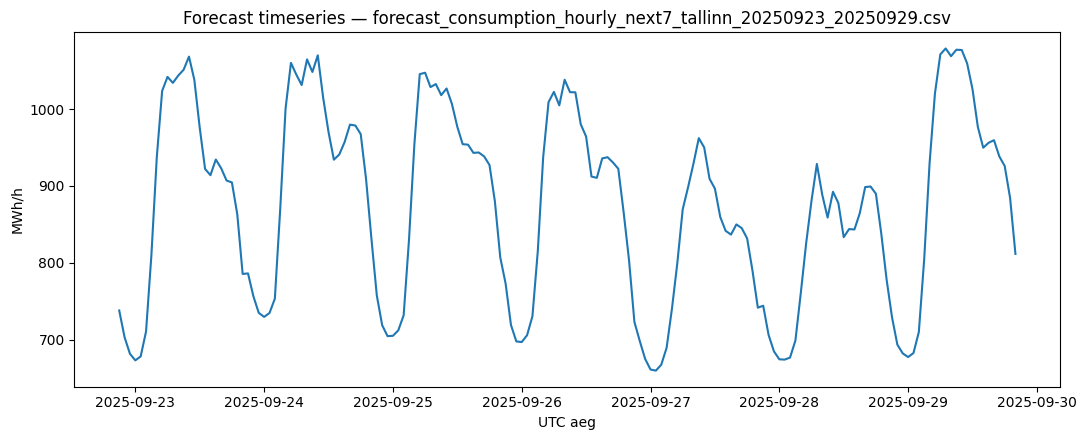

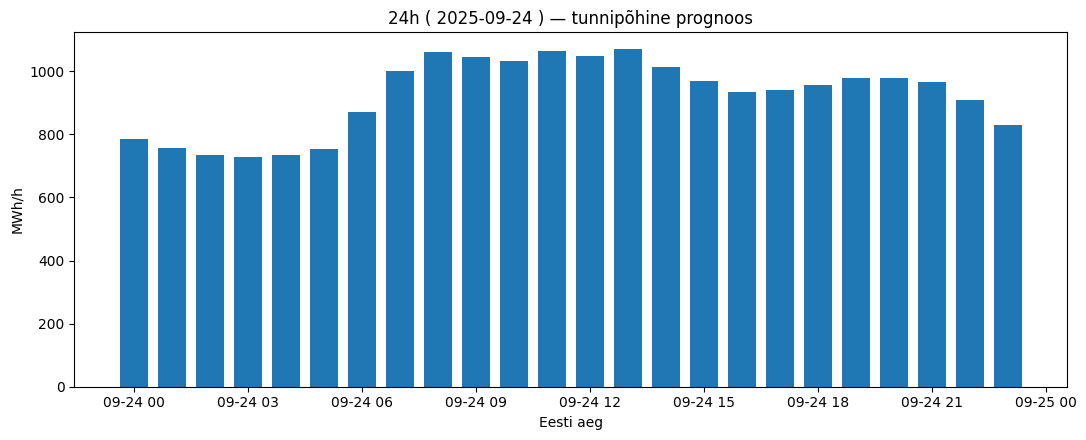

Salvestasin pildid: C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc\ts_latest.png C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc\hist_latest.png


In [87]:
# Kiired graafikud (kui faile on)
if not FILES:
    print("⏭️ Kiired graafikud vahele (faile ei leitud)")
else:
    latest_path = FILES[-1]
    latest = read_forecast(latest_path)
    # Ajarida (kogu horisont)
    plt.figure(figsize=(11,4.5))
    plt.plot(latest["datetime_hour"], latest["consumption_hourly"])
    plt.title(f"Forecast timeseries — {Path(latest_path).name}")
    plt.xlabel("UTC aeg"); plt.ylabel("MWh/h"); plt.tight_layout()
    plt.savefig(QC_DIR/"ts_latest.png", dpi=144); plt.show()

    # MUUDETUD: 24h (järgmine päev) tunnipõhine vaade tulpadena
    latest_local = latest.copy()
    latest_local['dt_local'] = latest_local['datetime_hour'].dt.tz_convert('Europe/Tallinn')
    latest_local['date_local'] = latest_local['dt_local'].dt.date
    today_local = pd.Timestamp.now(tz='Europe/Tallinn').date()
    next_day = today_local + pd.Timedelta(days=1)
    if (latest_local['date_local'] == next_day).any():
        day = next_day
    else:
        day = latest_local['date_local'].min()
    day_df = latest_local[latest_local['date_local'] == day]

    plt.figure(figsize=(11,4.5))
    plt.bar(day_df['dt_local'], day_df['consumption_hourly'], width=pd.Timedelta(minutes=45))
    plt.title(f"24h ( {day} ) — tunnipõhine prognoos")
    plt.xlabel("Eesti aeg"); plt.ylabel("MWh/h"); plt.tight_layout()
    # Säilitame sama failinime ühilduvuse huvides
    plt.savefig(QC_DIR/"hist_latest.png", dpi=144); plt.show()

    print("Salvestasin pildid:", (QC_DIR/"ts_latest.png"), (QC_DIR/"hist_latest.png"))

In [88]:
# Lõpp kokkuvõte
if not FILES:
    print("ℹ️ QC: ühtegi forecast-faili ei leitud. Pane failid kausta 'scripts/output' mustriga:")
    print("   ", GLOB_PATTERN)
    print("Seejärel käivita notebook uuesti.")
else:
    print("✅ QC valmis.")
    print("Raportid:")
    print(" -", (QC_DIR / "forecast_only_file_stats.csv"))
    latest_dq = sorted(QC_DIR.glob("forecast_only_dq_report_*.csv"))[-1] if list(QC_DIR.glob("forecast_only_dq_report_*.csv")) else None
    print(" -", latest_dq)
    if (QC_DIR/"overlap_drift_latest_vs_prev.csv").exists():
        print(" -", (QC_DIR/"overlap_drift_latest_vs_prev.csv"))
    if (QC_DIR/"per_file_dq_summary.csv").exists():
        print(" -", (QC_DIR/"per_file_dq_summary.csv"))
    if (QC_DIR/"drift_neighbors_summary.csv").exists():
        print(" -", (QC_DIR/"drift_neighbors_summary.csv"))
    print("Pildid:")
    print(" -", (QC_DIR/"ts_latest.png"))
    print(" -", (QC_DIR/"hist_latest.png"))
    if (QC_DIR/"drift_neighbors.png").exists():
        print(" -", (QC_DIR/"drift_neighbors.png"))

✅ QC valmis.
Raportid:
 - C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc\forecast_only_file_stats.csv
 - C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc\forecast_only_dq_report_20250923_0731.csv
 - C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc\overlap_drift_latest_vs_prev.csv
 - C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc\per_file_dq_summary.csv
 - C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc\drift_neighbors_summary.csv
Pildid:
 - C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc\ts_latest.png
 - C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\outp

## Kiired eelvaated raportitest
Alljärgnev kuvab olulisemad väljavõtted otse notebookis, et ei peaks CSV-faile eraldi avama.

In [89]:
from IPython.display import display
import pandas as pd
from pathlib import Path

# Eelvaadete teed
stats_csv = QC_DIR / "forecast_only_file_stats.csv"
dq_reports = sorted(QC_DIR.glob("forecast_only_dq_report_*.csv"))
dq_csv = dq_reports[-1] if dq_reports else None
drift_csv = QC_DIR / "overlap_drift_latest_vs_prev.csv"
perfile_csv = QC_DIR / "per_file_dq_summary.csv"
drift_neighbors_csv = QC_DIR / "drift_neighbors_summary.csv"

def show_head(path: Path, n=10):
    if not path or not Path(path).exists():
        print(f"(Puudub) {path}")
        return
    print("\n","="*12, Path(path).name, "="*12)
    try:
        df = pd.read_csv(path, sep=";", encoding="utf-8")
    except UnicodeDecodeError:
        df = pd.read_csv(path, sep=";", encoding="latin-1")
    display(df.head(n))
    print("(… kokku", len(df), "rida)")

print("Eelvaated QC CSV-dest:")
show_head(stats_csv, n=12)
show_head(dq_csv, n=20)
show_head(drift_csv, n=15)
show_head(perfile_csv, n=12)
show_head(drift_neighbors_csv, n=12)

Eelvaated QC CSV-dest:

 ============ forecast_only_file_stats.csv ============


,file,rows,unique_ts,duplicates,expected_hours_from_filename,rows_vs_filename,hourly_step_share,missing_hours_inside_range,na_share,negative_share,min,max,mean
0,forecast_consumption_hourly_next7_tallinn_2025...,168,168,0,168,PASS,1.0,0,0.0,0.0,616.942194,1062.248315,832.177738
1,forecast_consumption_hourly_next7_tallinn_2025...,168,168,0,168,PASS,1.0,0,0.0,0.0,605.451847,1070.095781,840.231250
2,forecast_consumption_hourly_next7_tallinn_2025...,168,168,0,168,PASS,1.0,0,0.0,0.0,588.578873,1069.808146,844.014107
3,forecast_consumption_hourly_next7_tallinn_2025...,168,168,0,168,PASS,1.0,0,0.0,0.0,659.640659,1078.890045,875.582440


(… kokku 4 rida)

 ============ forecast_only_dq_report_20250923_0731.csv ============


,check,value,threshold,status_or_note
0,file_latest,forecast_consumption_hourly_next7_tallinn_2025...,INFO,NaN
1,hourly_step_share,1.0,1.0=OK,PASS — 1.0 tähendab kõigil vahedel 1h
2,missing_hours_inside_range,0,0,PASS — 0 tähendab ühtegi tundi ei puudu vahemi...
3,na_share,0.0,≤1% (PASS) / ≤5% (WARN),PASS
4,negative_share,0.0,0%,PASS
5,outlier_share_vs_allfiles,0.0,≤1% (PASS) / ≤3% (WARN),PASS [robust range 205…1510]


(… kokku 6 rida)

 ============ overlap_drift_latest_vs_prev.csv ============


,datetime_hour,consumption_hourly_new,consumption_hourly_old,rel_diff,file_new,file_old
0,2025-09-26 13:00:00+00:00,912.162556,954.334930,0.045189,forecast_consumption_hourly_next7_tallinn_2025...,forecast_consumption_hourly_next7_tallinn_2025...
1,2025-09-26 00:00:00+00:00,696.797452,723.378577,0.037434,forecast_consumption_hourly_next7_tallinn_2025...,forecast_consumption_hourly_next7_tallinn_2025...
2,2025-09-26 14:00:00+00:00,910.509441,944.832644,0.036999,forecast_consumption_hourly_next7_tallinn_2025...,forecast_consumption_hourly_next7_tallinn_2025...
3,2025-09-25 23:00:00+00:00,697.639423,722.613899,0.035169,forecast_consumption_hourly_next7_tallinn_2025...,forecast_consumption_hourly_next7_tallinn_2025...
4,2025-09-26 11:00:00+00:00,980.265122,1011.186260,0.031054,forecast_consumption_hourly_next7_tallinn_2025...,forecast_consumption_hourly_next7_tallinn_2025...
5,2025-09-26 08:00:00+00:00,1038.157267,1069.808146,0.030030,forecast_consumption_hourly_next7_tallinn_2025...,forecast_consumption_hourly_next7_tallinn_2025...
6,2025-09-26 12:00:00+00:00,964.205187,993.113814,0.029539,forecast_consumption_hourly_next7_tallinn_2025...,forecast_consumption_hourly_next7_tallinn_2025...
7,2025-09-25 22:00:00+00:00,718.955926,739.686406,0.028424,forecast_consumption_hourly_next7_tallinn_2025...,forecast_consumption_hourly_next7_tallinn_2025...
8,2025-09-26 01:00:00+00:00,705.706393,725.668637,0.027892,forecast_consumption_hourly_next7_tallinn_2025...,forecast_consumption_hourly_next7_tallinn_2025...
9,2025-09-26 15:00:00+00:00,935.776037,961.804687,0.027434,forecast_consumption_hourly_next7_tallinn_2025...,forecast_consumption_hourly_next7_tallinn_2025...


(… kokku 30 rida)

 ============ per_file_dq_summary.csv ============


,file,pass,warn,fail,rows,unique_ts,duplicates,missing_inside,hourly_step_share,na_share,negative_share,outlier_share,min,mean,max
0,forecast_consumption_hourly_next7_tallinn_2025...,5,0,0,168,168,0,0,1.0,0.0,0.0,0.0,616.942194,832.177738,1062.248315
1,forecast_consumption_hourly_next7_tallinn_2025...,5,0,0,168,168,0,0,1.0,0.0,0.0,0.0,605.451847,840.231250,1070.095781
2,forecast_consumption_hourly_next7_tallinn_2025...,5,0,0,168,168,0,0,1.0,0.0,0.0,0.0,588.578873,844.014107,1069.808146
3,forecast_consumption_hourly_next7_tallinn_2025...,5,0,0,168,168,0,0,1.0,0.0,0.0,0.0,659.640659,875.582440,1078.890045


(… kokku 4 rida)

 ============ drift_neighbors_summary.csv ============


,file_old,file_new,overlap_hours,drift_share_rel>1%,drift_share_rel>3%,max_rel_diff,max_rel_diff_at
0,forecast_consumption_hourly_next7_tallinn_2025...,forecast_consumption_hourly_next7_tallinn_2025...,144,0.381944,0.013889,0.037520,2025-09-24 08:00:00+00:00
1,forecast_consumption_hourly_next7_tallinn_2025...,forecast_consumption_hourly_next7_tallinn_2025...,144,0.361111,0.166667,0.034337,2025-09-22 13:00:00+00:00
2,forecast_consumption_hourly_next7_tallinn_2025...,forecast_consumption_hourly_next7_tallinn_2025...,96,0.479167,0.062500,0.045189,2025-09-26 13:00:00+00:00


(… kokku 3 rida)


## Kokkuvõtlik statistika
Lühike ülevaade QC tulemustest: koond PASS/WARN/FAIL, viimase faili põhinäitajad ja drift.

In [90]:
import pandas as pd
import numpy as np
from pathlib import Path

# Laadi koondfailid kui olemas
stats_csv = QC_DIR / "forecast_only_file_stats.csv"
dq_reports = sorted(QC_DIR.glob("forecast_only_dq_report_*.csv"))
dq_csv = dq_reports[-1] if dq_reports else None
drift_csv = QC_DIR / "overlap_drift_latest_vs_prev.csv"

def read_csv_safe(path: Path, sep=";", encs=("utf-8","latin-1")):
    if not path or not Path(path).exists():
        return None
    for e in encs:
        try:
            return pd.read_csv(path, sep=sep, encoding=e)
        except Exception:
            continue
    return None

stats = read_csv_safe(stats_csv)
dq = read_csv_safe(dq_csv)
drift = read_csv_safe(drift_csv)

summary_rows = []
notes = []

# 1) DQ PASS/WARN/FAIL kokkuvõte — NB! see koondab AINULT viimase faili kontrollid,
#    mitte failide arvu. PASS=3 tähendab, et viimase faili kolmel kontrollil oli PASS.
if dq is not None and not dq.empty:
    status_col = dq.get("status_or_note")
    if status_col is not None:
        statuses = status_col.dropna().astype(str)
        pass_n = int((statuses.str.contains(r"\bPASS\b")).sum())
        warn_n = int((statuses.str.contains(r"\bWARN\b")).sum())
        fail_n = int((statuses.str.contains(r"\bFAIL\b")).sum())
        summary_rows.append({"group":"Latest file DQ checks","PASS": pass_n, "WARN": warn_n, "FAIL": fail_n})
else:
    notes.append("DQ raportit ei leitud — PASS/WARN/FAIL kokkuvõte puudub.")

# 2) Viimase faili põhinäitajad — eelis: arvuta otse viimasest failist, kui võimalik
latest_vals = None
try:
    if 'FILES' in globals() and FILES:
        latest_path = FILES[-1]
        latest_df = read_forecast(latest_path)
        rows = int(len(latest_df))
        uniq = int(latest_df["datetime_hour"].nunique())
        dups = int(rows - uniq)
        rng = pd.date_range(latest_df["datetime_hour"].min(), latest_df["datetime_hour"].max(), freq="h", tz="UTC") if rows else pd.DatetimeIndex([])
        missing_inside = int(len(rng.difference(latest_df["datetime_hour"])) if rows else 0)
        step_ok = float(hourly_step_share(latest_df["datetime_hour"]))
        na_share = float(latest_df["consumption_hourly"].isna().mean())
        neg_share = float((latest_df["consumption_hourly"] < 0).mean())
        vmin = float(latest_df["consumption_hourly"].min())
        vmean = float(latest_df["consumption_hourly"].mean())
        vmax = float(latest_df["consumption_hourly"].max())
        latest_vals = {
            "group":"Latest file basics",
            "rows": rows, "unique_ts": uniq, "duplicates": dups,
            "missing_inside": missing_inside, "hourly_step_share": step_ok,
            "na_share": na_share, "negative_share": neg_share,
            "min": vmin, "mean": vmean, "max": vmax,
        }
except Exception as e:
    notes.append(f"Viimase faili lugemine ebaõnnestus: {e}")

# Kui otse arvutus ei õnnestu, proovi võtta stats CSV-st (võib sisaldada NaN-e)
if latest_vals is None and stats is not None and not stats.empty and "file" in stats.columns:
    last_row = stats.sort_values("file").iloc[-1]
    def gnum(col):
        val = last_row.get(col, np.nan)
        return None if pd.isna(val) else float(val)
    latest_vals = {
        "group":"Latest file basics (from stats)",
        "rows": gnum("rows"),
        "unique_ts": gnum("unique_ts"),
        "duplicates": gnum("duplicates"),
        "missing_inside": gnum("missing_hours_inside_range"),
        "hourly_step_share": gnum("hourly_step_share"),
        "na_share": gnum("na_share"),
        "negative_share": gnum("negative_share"),
        "min": gnum("min"),
        "mean": gnum("mean"),
        "max": gnum("max"),
    }

if latest_vals is not None:
    summary_rows.append(latest_vals)
else:
    notes.append("Viimase faili põhinäitajad puuduvad — ei leitud FILES nimekirja ega stats CSV-d.")

# 3) Drift kokkuvõte
if drift is not None and not drift.empty:
    summary_rows.append({"group":"Drift overlap rows","rows": int(len(drift))})
else:
    if not ('FILES' in globals() and FILES and len(FILES) >= 2):
        notes.append("Drift N/A — vaja vähemalt kahte forecast-faili.")

# Väljasta tabel ja vorming
if summary_rows:
    summary_df = pd.DataFrame(summary_rows)
    # Vorminda protsendiveerud; tühjad jäta tühjaks
    fmt_df = summary_df.copy()
    for col in ["hourly_step_share","na_share","negative_share"]:
        if col in fmt_df.columns:
            fmt_df[col] = fmt_df[col].apply(lambda x: (f"{x*100:.1f}%" if pd.notna(x) else ""))
    # Kuva loendurid täisarvudena (stringid), puuduvad väärtused tühjaks
    counter_cols = ["PASS","WARN","FAIL","rows","unique_ts","duplicates","missing_inside"]
    for icol in counter_cols:
        if icol in fmt_df.columns:
            fmt_df[icol] = pd.to_numeric(fmt_df[icol], errors="coerce").astype("Int64").astype("string")
    # Ülejäänud numbrid veidi kompaktsemaks
    for fcol in ["min","mean","max"]:
        if fcol in fmt_df.columns:
            fmt_df[fcol] = pd.to_numeric(fmt_df[fcol], errors="coerce").round(3)
    # Asenda ülejäänud NaN-id tühjadega (pärast int->string teisendust)
    fmt_df = fmt_df.fillna("")
    display(fmt_df)

    # Grupi lühiselgitused (et oleks kohe selge, mida iga rida tähendab)
    groups_order = list(dict.fromkeys(summary_df["group"].tolist()))  # unikaalsed grupid algse järjekorra järgi
    group_help = {
        "Latest file DQ checks": "Viimase faili kvaliteedikontrollide koond: mitu kontrolli said PASS/WARN/FAIL (see EI näita failide arvu).",
        "Latest file basics": "Viimase faili põhinäitajad: read, unikaalsed tunnid, duplikaadid, puuduvad tunnid, 1h sammujärgsus, NA/negatiivsete osakaal, min/mean/max.",
        "Latest file basics (from stats)": "Sama mis 'Latest file basics', kuid tuletatud koondstatistikast, kui otse arvutamine ebaõnnestus.",
        "Drift overlap rows": "Ridade arv drifti top-30 failis (uus vs eelmine fail): kattuvate tundide kõige suurema relatiivse erinevusega ajad.",
    }
    explain_df = pd.DataFrame({
        "group": groups_order,
        "selgitus": [group_help.get(g, "") for g in groups_order]
    })
    print("\nGrupi lühiselgitused:")
    styler = (
        explain_df.style
        .hide(axis="index")
        .set_table_styles([
            {"selector": "table", "props": [("table-layout", "fixed"), ("width", "100%")]},
            {"selector": "th", "props": [("text-align", "left")]},
            {"selector": "td", "props": [("text-align", "left"), ("white-space", "pre-wrap"), ("vertical-align", "top")]},
            {"selector": "th.col_heading.level0.col0", "props": [("width", "33%")]},
            {"selector": "td.col0", "props": [("width", "33%")]},
            {"selector": "th.col_heading.level0.col1", "props": [("width", "67%")]},
            {"selector": "td.col1", "props": [("width", "67%")]},
        ])
    )
    display(styler)
else:
    print("(Statistika: ei leidnud midagi kokku võtta — veendu, et eelnevad QC rakud jooksid ja CSV-d on olemas)")

# Lisa märkused
if notes:
    print("\nMärkused:")
    for n in notes:
        print(" -", n)

,group,PASS,WARN,FAIL,rows,unique_ts,duplicates,missing_inside,hourly_step_share,na_share,negative_share,min,mean,max
0,Latest file DQ checks,5,0,0,,,,,,,,,,
1,Latest file basics,,,,168,168,0,0,100.0%,0.0%,0.0%,659.641,875.582,1078.89
2,Drift overlap rows,,,,30,,,,,,,,,



Grupi lühiselgitused:


group,selgitus
Latest file DQ checks,Viimase faili kvaliteedikontrollide koond: mitu kontrolli said PASS/WARN/FAIL (see EI näita failide arvu).
Latest file basics,"Viimase faili põhinäitajad: read, unikaalsed tunnid, duplikaadid, puuduvad tunnid, 1h sammujärgsus, NA/negatiivsete osakaal, min/mean/max."
Drift overlap rows,Ridade arv drifti top-30 failis (uus vs eelmine fail): kattuvate tundide kõige suurema relatiivse erinevusega ajad.


## Per-file DQ kokkuvõte
See tabel võtab kokku DQ tulemused KÕIGI prognoosifailide kohta eraldi (mitte ainult viimase faili kohta):
- Loendab, mitu kontrolli sai PASS/WARN/FAIL iga faili kohta.
- Näitab ka põhinäitajaid (read, unikaalsed tunnid, puuduvad tunnid, NA/negatiivsed/osakaal outliere).
Tulemus salvestatakse ka CSV-faili kausta `scripts/output/qc` nimega `per_file_dq_summary.csv`. 

In [91]:
# Per-file DQ kokkuvõtte arvutus ja salvestus
from pathlib import Path
import pandas as pd
import numpy as np

if not FILES:
    print("⏭️ Per-file DQ vahele (faile ei leitud)")
else:
    rows = []
    # Püüa laadida robustsed piirid, kui need olemas
    limits = None
    try:
        lim_json = pd.read_json(QC_DIR/"robust_limits.json", typ="series")
        limits = {"lower": float(lim_json.get("lower", np.nan)), "upper": float(lim_json.get("upper", np.nan))}
    except Exception:
        limits = None

    for p in FILES:
        df = read_forecast(p)
        fname = Path(p).name
        # põhinäitajad
        total_rows = int(len(df))
        uniq = int(df["datetime_hour"].nunique())
        dups = int(total_rows - uniq)
        if total_rows:
            rng = pd.date_range(df["datetime_hour"].min(), df["datetime_hour"].max(), freq="h", tz="UTC")
            missing_inside = int(len(rng.difference(df["datetime_hour"])))
        else:
            missing_inside = 0
        step_ok = float(hourly_step_share(df["datetime_hour"]))
        na_share = float(df["consumption_hourly"].isna().mean())
        neg_share = float((df["consumption_hourly"] < 0).mean())
        if limits is not None and not np.isnan(limits.get("lower", np.nan)) and not np.isnan(limits.get("upper", np.nan)):
            out_share = float(((df["consumption_hourly"] < limits["lower"]) | (df["consumption_hourly"] > limits["upper"]).fillna(False)).mean())
        else:
            out_share = np.nan

        # kontrollide staatused
        step_status = "PASS" if step_ok == 1.0 else "FAIL"
        miss_status = "PASS" if missing_inside == 0 else "FAIL"
        def mark_share(val, pass_max, warn_max):
            if np.isnan(val):
                return "N/A"
            if val <= pass_max: return "PASS"
            if val <= warn_max: return "WARN"
            return "FAIL"
        na_status  = mark_share(na_share, THRESH["max_na_share"], THRESH["warn_na_share"]) 
        neg_status = mark_share(neg_share, THRESH["max_negative_share"], THRESH["max_negative_share"]) 
        out_status = mark_share(out_share, THRESH["max_outlier_share"], THRESH["warn_outlier_share"]) if not np.isnan(out_share) else "N/A"

        statuses = [step_status, miss_status, na_status, neg_status, out_status]
        pass_n = sum(s == "PASS" for s in statuses)
        warn_n = sum(s == "WARN" for s in statuses)
        fail_n = sum(s == "FAIL" for s in statuses)

        rows.append({
            "file": fname,
            "pass": pass_n,
            "warn": warn_n,
            "fail": fail_n,
            "rows": total_rows,
            "unique_ts": uniq,
            "duplicates": dups,
            "missing_inside": missing_inside,
            "hourly_step_share": step_ok,
            "na_share": na_share,
            "negative_share": neg_share,
            "outlier_share": out_share,
            "min": float(df["consumption_hourly"].min()) if total_rows else np.nan,
            "mean": float(df["consumption_hourly"].mean()) if total_rows else np.nan,
            "max": float(df["consumption_hourly"].max()) if total_rows else np.nan,
        })

    per_file_dq = pd.DataFrame(rows).sort_values("file").reset_index(drop=True)
    # Vormindus kuvamiseks
    disp = per_file_dq.copy()
    disp["hourly_step_share"] = (disp["hourly_step_share"]*100).round(1).astype(str) + "%"
    for col in ["na_share","negative_share","outlier_share"]:
        if col in disp.columns:
            disp[col] = (disp[col]*100).round(1).astype("Float64").astype("string").str.replace("<NA>", "") + "%"
            disp[col] = disp[col].str.replace("nan%", "")
    for col in ["rows","unique_ts","duplicates","missing_inside","pass","warn","fail"]:
        if col in disp.columns:
            disp[col] = pd.to_numeric(disp[col], errors="coerce").astype("Int64").astype("string")
    for col in ["min","mean","max"]:
        if col in disp.columns:
            disp[col] = pd.to_numeric(disp[col], errors="coerce").round(3)
    disp = disp.fillna("")

    # Salvesta CSV
    out_csv = QC_DIR / "per_file_dq_summary.csv"
    per_file_dq.to_csv(out_csv, sep=";", index=False, encoding="utf-8")

    print("Per-file DQ kokkuvõte salvestatud:", out_csv)
    display(disp)

Per-file DQ kokkuvõte salvestatud: C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc\per_file_dq_summary.csv


,file,pass,warn,fail,rows,unique_ts,duplicates,missing_inside,hourly_step_share,na_share,negative_share,outlier_share,min,mean,max
0,forecast_consumption_hourly_next7_tallinn_2025...,5,0,0,168,168,0,0,100.0%,0.0%,0.0%,0.0%,616.942,832.178,1062.248
1,forecast_consumption_hourly_next7_tallinn_2025...,5,0,0,168,168,0,0,100.0%,0.0%,0.0%,0.0%,605.452,840.231,1070.096
2,forecast_consumption_hourly_next7_tallinn_2025...,5,0,0,168,168,0,0,100.0%,0.0%,0.0%,0.0%,588.579,844.014,1069.808
3,forecast_consumption_hourly_next7_tallinn_2025...,5,0,0,168,168,0,0,100.0%,0.0%,0.0%,0.0%,659.641,875.582,1078.890


## Naaberfailide drift kokkuvõte (kõik paarid)
Allpool võrdleme järjestikuseid prognoosifaile (old → new) ja arvutame drift-näitajad:
- overlap_hours: tundide arv, mis mõlemal failil kattuvad
- drift_share_rel>1%, drift_share_rel>3%: kui suur osa kattuvatest tundidest ületab vastava relatiivse erinevuse
- max_rel_diff ja selle ajamärk: suurim leitud relatiivne erinevus ja aeg
Tulemus salvestatakse CSV-na `scripts/output/qc/drift_neighbors_summary.csv`. 

In [92]:
# Drift naaberpaaridele (kõik järjestikused failid)
import pandas as pd
import numpy as np
from pathlib import Path

if not FILES or len(FILES) < 2:
    print("⏭️ Naaberfailide drift vahele (vähem kui 2 faili)")
else:
    rows = []
    for i in range(1, len(FILES)):
        old_p = FILES[i-1]
        new_p = FILES[i]
        old = read_forecast(old_p)
        new = read_forecast(new_p)
        overlap = new.merge(old, on="datetime_hour", how="inner", suffixes=("_new","_old"))
        if overlap.empty:
            rows.append({
                "file_old": Path(old_p).name, "file_new": Path(new_p).name,
                "overlap_hours": 0,
                "drift_share_rel>1%": np.nan,
                "drift_share_rel>3%": np.nan,
                "max_rel_diff": np.nan,
                "max_rel_diff_at": "",
            })
            continue
        denom = (overlap["consumption_hourly_new"].abs() + overlap["consumption_hourly_old"].abs())/2.0
        overlap["rel_diff"] = np.where(denom>0, (overlap["consumption_hourly_new"]-overlap["consumption_hourly_old"]).abs()/denom, 0.0)
        drift_1 = float((overlap["rel_diff"] > 0.01).mean())
        drift_3 = float((overlap["rel_diff"] > 0.03).mean())
        idxmax = overlap["rel_diff"].idxmax()
        max_rel = float(overlap.loc[idxmax, "rel_diff"]) if len(overlap) else np.nan
        max_at = overlap.loc[idxmax, "datetime_hour"] if len(overlap) else ""
        rows.append({
            "file_old": Path(old_p).name, "file_new": Path(new_p).name,
            "overlap_hours": int(len(overlap)),
            "drift_share_rel>1%": drift_1,
            "drift_share_rel>3%": drift_3,
            "max_rel_diff": max_rel,
            "max_rel_diff_at": max_at,
        })

    drift_nei = pd.DataFrame(rows)
    # Kuvamise vormindus
    disp = drift_nei.copy()
    for col in ["drift_share_rel>1%","drift_share_rel>3%"]:
        if col in disp.columns:
            disp[col] = (pd.to_numeric(disp[col], errors="coerce")*100).round(1).astype("Float64").astype("string").str.replace("<NA>", "") + "%"
            disp[col] = disp[col].str.replace("nan%", "")
    if "overlap_hours" in disp.columns:
        disp["overlap_hours"] = pd.to_numeric(disp["overlap_hours"], errors="coerce").astype("Int64").astype("string")
    if "max_rel_diff" in disp.columns:
        disp["max_rel_diff"] = (pd.to_numeric(disp["max_rel_diff"], errors="coerce")*100).round(1)
    disp = disp.fillna("")

    out_csv = QC_DIR / "drift_neighbors_summary.csv"
    drift_nei.to_csv(out_csv, sep=";", index=False, encoding="utf-8")
    print("Naaberfailide drift kokkuvõte salvestatud:", out_csv)
    display(disp)

Naaberfailide drift kokkuvõte salvestatud: C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc\drift_neighbors_summary.csv
 C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc\drift_neighbors_summary.csv


,file_old,file_new,overlap_hours,drift_share_rel>1%,drift_share_rel>3%,max_rel_diff,max_rel_diff_at
0,forecast_consumption_hourly_next7_tallinn_2025...,forecast_consumption_hourly_next7_tallinn_2025...,144,38.2%,1.4%,3.8,2025-09-24 08:00:00+00:00
1,forecast_consumption_hourly_next7_tallinn_2025...,forecast_consumption_hourly_next7_tallinn_2025...,144,36.1%,16.7%,3.4,2025-09-22 13:00:00+00:00
2,forecast_consumption_hourly_next7_tallinn_2025...,forecast_consumption_hourly_next7_tallinn_2025...,96,47.9%,6.2%,4.5,2025-09-26 13:00:00+00:00


## Graafik: naaberfailide drift
Allolev graafik kasutab Y-teljel kompaktseid paarinumbreid (#1, #2, …). Täisnimed on toodud graafiku all mitmes veerus, et ruumikasutus oleks parem.
- Drift_share_rel>1% ja >3% (sinine ja oranž riba, X-teljel %)
- Overlap_hours (hele roheline riba teisel X-teljel)

Pilt salvestatakse ka kausta `scripts/output/qc/drift_neighbors.png`. 

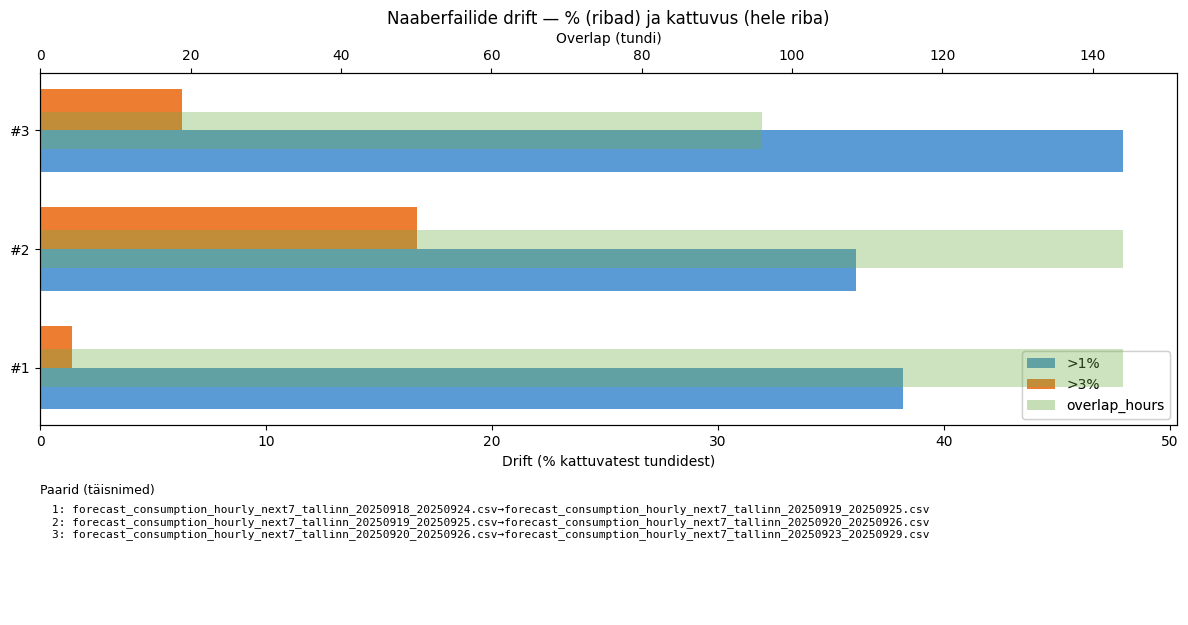

Salvestatud graafik: C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc\drift_neighbors.png


In [93]:
# Joonista naaberfailide driftist koondgraafik (kompaktne telg + täiskirjeldus graafiku all mitmes veerus)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

csv_path = QC_DIR / "drift_neighbors_summary.csv"
if not csv_path.exists():
    print("⏭️ Graafik vahele — drift_neighbors_summary.csv puudub. Käivita eelmine rakk.")
else:
    df = pd.read_csv(csv_path, sep=";", encoding="utf-8")
    if df.empty:
        print("⏭️ Graafik vahele — drift_neighbors_summary.csv on tühi.")
    else:
        # Kompaktne Y-telg: kasutame paarinumbreid #1, #2, ...; täisnimed graafiku all mitmes veerus
        pair_ids = [f"#{i+1}" for i in range(len(df))]
        mapping_lines = [f"{i+1}: {row['file_old']}→{row['file_new']}" for i, (_, row) in enumerate(df.iterrows())]

        d1 = pd.to_numeric(df["drift_share_rel>1%"], errors="coerce") * 100.0
        d3 = pd.to_numeric(df["drift_share_rel>3%"], errors="coerce") * 100.0
        ovl = pd.to_numeric(df["overlap_hours"], errors="coerce")

        y = np.arange(len(df))
        bar_h = 0.35
        off = bar_h / 2

        # Arvuta dünaamiline kõrgus ja allpaneeli suhe tekstiplokiga
        n = len(mapping_lines)
        if n <= 15:
            ncols = 1
        elif n <= 30:
            ncols = 2
        else:
            ncols = 3
        rows_per_col = int(np.ceil(n / max(1, ncols)))
        fig_w = max(12, len(df)*0.9)
        bottom_extra = max(1.2, min(6.0, 0.25*rows_per_col + 0.6))
        fig_h = max(5, len(df)*0.5) + bottom_extra
        map_ratio = min(3.0, 0.6 + 0.12*rows_per_col)

        # Loo kaks rida: üleval graafik, all täisnimede paneel
        fig = plt.figure(figsize=(fig_w, fig_h))
        gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[3, map_ratio])
        ax1 = fig.add_subplot(gs[0])

        # Drift ribad (esmane X-telg)
        ax1.barh(y - off, d1.fillna(0), height=bar_h, label=">1%", color="#5b9bd5")
        ax1.barh(y + off, d3.fillna(0), height=bar_h, label=">3%", color="#ed7d31")

        # Overlap ribad (teine X-telg)
        ax2 = ax1.twiny()
        ax2.barh(y, ovl.fillna(0), height=bar_h*0.9, label="overlap_hours", color="#70ad47", alpha=0.35)

        # Teljed ja sildid
        ax1.set_yticks(y)
        ax1.set_yticklabels(pair_ids)
        ax1.set_xlabel("Drift (% kattuvatest tundidest)")
        ax2.set_xlabel("Overlap (tundi)")
        ax1.set_title("Naaberfailide drift — % (ribad) ja kattuvus (hele riba)")

        # Seeria legend (drift ja overlap)
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        leg1 = ax1.legend(h1 + h2, l1 + l2, loc="lower right")
        ax1.add_artist(leg1)

        # Allpaneel täisnimedega mitmes veerus
        panel = fig.add_subplot(gs[1])
        panel.axis('off')
        panel.set_title("Paarid (täisnimed)", fontsize=9, loc='left')

        for c in range(ncols):
            lines = mapping_lines[c*rows_per_col:(c+1)*rows_per_col]
            text = "\n".join(lines)
            x = (c + 0.01) / max(1, ncols)
            panel.text(x, 0.98, text, va='top', ha='left', fontsize=8, family='monospace', transform=panel.transAxes)

        plt.tight_layout()
        out_png = QC_DIR / "drift_neighbors.png"
        plt.savefig(out_png, dpi=160)
        plt.show()
        print("Salvestatud graafik:", out_png)